# ESRGAN - Super Resolution GAN

## Importing the libraries


In [1]:
import os
import glob
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow

In [2]:
!git clone https://github.com/xinntao/ESRGAN

Cloning into 'ESRGAN'...
remote: Enumerating objects: 225, done.
remote: Total 225 (delta 0), reused 0 (delta 0), pack-reused 225
Receiving objects: 100% (225/225), 24.86 MiB | 31.62 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [3]:
!pwd

/content


In [4]:
%cd /content/ESRGAN

/content/ESRGAN


In [5]:
!pwd

/content/ESRGAN


In [6]:
import RRDBNet_arch as arch

## Downloading the pretrained model




In [7]:
model_name = 'RRDB_ESRGAN_x4.pth'
models_dir = 'models/'

In [8]:
environment = 'cuda' # cpu
device = torch.device(environment)

In [9]:
!nvidia-smi

Tue Jul  4 03:15:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Available models:
* RRDB_ESRGAN_x4.pth
* RRDB_PSNR_x4.pth

Pretrained ESRGAN models [here](https://drive.google.com/drive/u/0/folders/17VYV_SoZZesU6mbxz2dMAIccSSlqLecY). Other link: https://github.com/xinntao/ESRGAN#test-models


In [10]:
import gdown

In [11]:
model_1 = '{}RRDB_ESRGAN_x4.pth'.format(models_dir)
model_2 = '{}RRDB_PSNR_x4.pth'.format(models_dir)
print(model_1, model_2)

models/RRDB_ESRGAN_x4.pth models/RRDB_PSNR_x4.pth


In [12]:
gdown.download('https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene', model_1)
gdown.download('https://drive.google.com/uc?id=1pJ_T-V1dpb1ewoEra1TGSWl5e6H7M4NN', model_2)

Downloading...
From: https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene
To: /content/ESRGAN/models/RRDB_ESRGAN_x4.pth
100%|██████████| 66.9M/66.9M [00:00<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pJ_T-V1dpb1ewoEra1TGSWl5e6H7M4NN
To: /content/ESRGAN/models/RRDB_PSNR_x4.pth
100%|██████████| 66.9M/66.9M [00:01<00:00, 62.2MB/s]


'models/RRDB_PSNR_x4.pth'


More about the function and its parameters: https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

PyTorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


In [13]:
def load_model(model_name, model_dir, device):
  model_path = "{}{}".format(model_dir, model_name)
  model = arch.RRDBNet(3, 3, 64, 23, gc = 32)
  model.load_state_dict(torch.load(model_path), strict = True)
  model.eval()
  model = model.to(device)
  return model

In [14]:
model = load_model(model_name, models_dir, device)

## Testing images

In [15]:
# montain, urban, lego, flowers, simpsons02, island

In [16]:
images_dir = '/content/ESRGAN/LR/'

In [20]:
name_img = '{}ahmet.jpg'.format(images_dir)
name_img

'/content/ESRGAN/LR/ahmet.jpg'

In [21]:
img = cv2.imread(name_img)
img.shape

(1024, 768, 3)

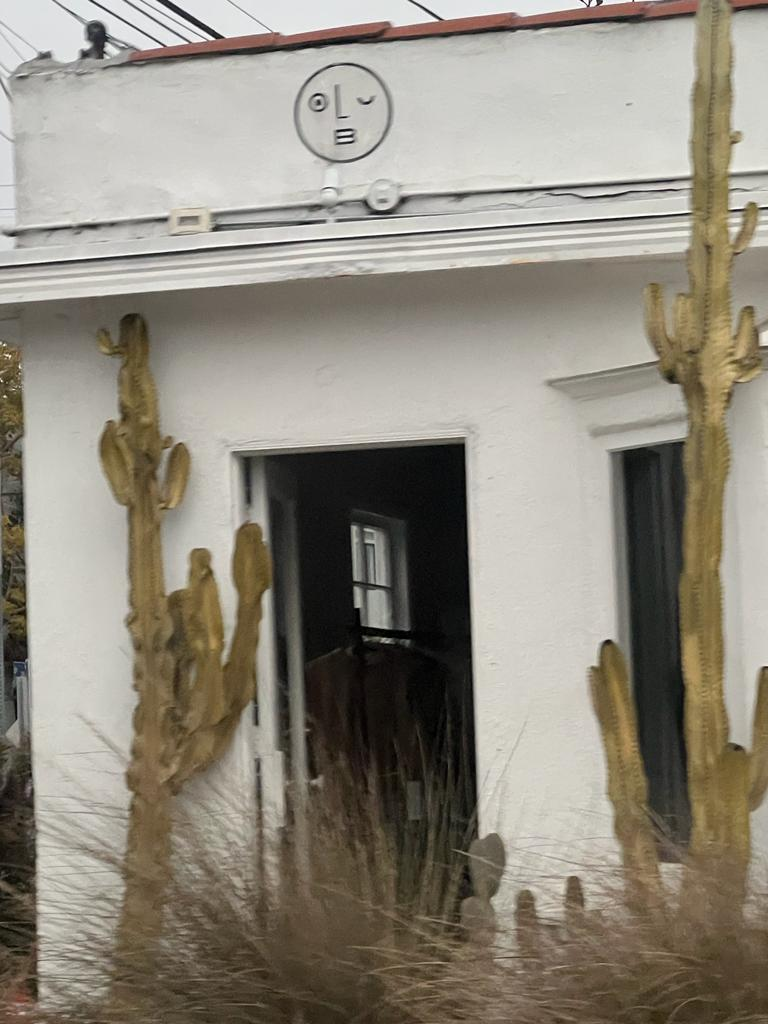

In [22]:
cv2_imshow(img)

## Super Resolution

In [23]:
def super_resolution(path_img, device, model):
  base = os.path.splitext(os.path.basename(path_img))[0]
  #print(base)
  img = cv2.imread(path_img)
  img = img * 1.0 / 255
  #print(img.shape)
  img = torch.from_numpy(np.transpose(img[:,:, [2,1,0]], (2,0,1))).float()
  #print(img.shape)
  LR = img.unsqueeze(0)
  #print(LR.shape)
  LR = LR.to(device)

  with torch.no_grad():
    result = model(LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
  result = np.transpose(result[[2,1,0], :, :], (1,2,0))
  result = (result * 255.0).round()
  cv2.imwrite('results/{:s}_sr.png'.format(base), result)
  return result

In [ ]:
result_sr = super_resolution(name_img, device, model)
print(result_sr.shape)
cv2_imshow(result_sr)

## Evaluating the results

In [ ]:
img = cv2.imread(name_img)
bicubic_result = cv2.resize(img, (0,0), fx = 4.0, fy = 4.0, interpolation=cv2.INTER_CUBIC)
cv2_imshow(bicubic_result)

### Artifacts

- More information: https://en.wikipedia.org/wiki/Compression_artifact



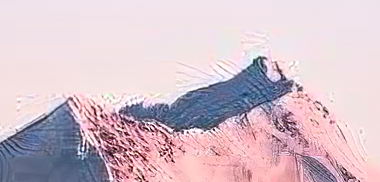

## PSNR

Peak Single to Noise Ratio ([PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is one of the most used metrics to measure the quality of reconstruction compressed images

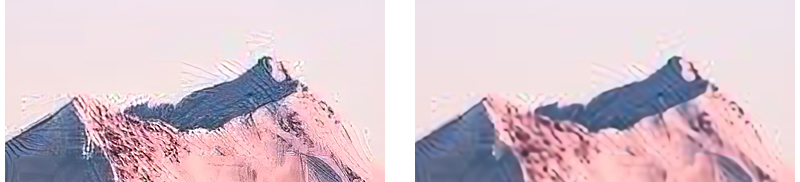

In [ ]:
model_name = 'RRDB_PSNR_x4.pth'
model = load_model(model_name, models_dir, device)
result_sr = super_resolution(name_img, device, model)
print(result_sr.shape)
cv2_imshow(result_sr)

In [32]:
result_small = cv2.resize(result_sr, (0,0), fx = 0.5, fy = 0.5)
print(result_small.shape)
cv2_imshow(result_small)

Output hidden; open in https://colab.research.google.com to view.

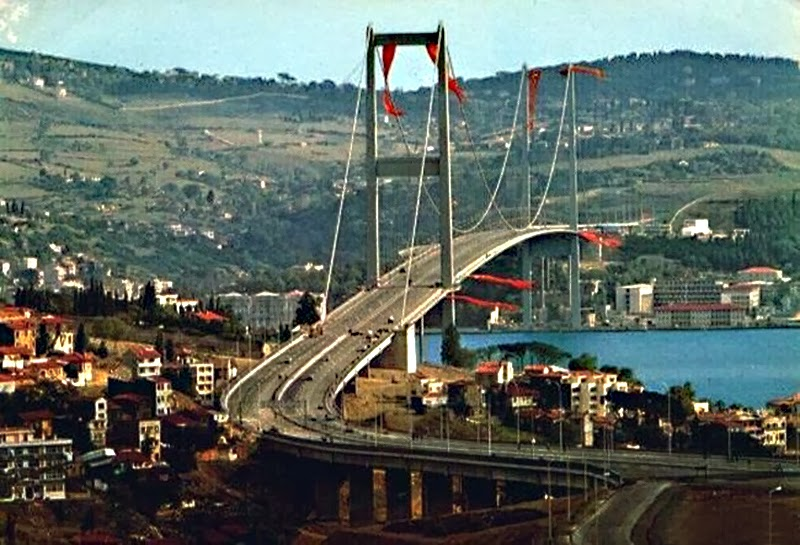

In [33]:
cv2_imshow(img)

## Multiple images

In [38]:
directory = '/content/ESRGAN/LR/*'

In [39]:
for image in glob.glob(directory):
  result_sr = super_resolution(image, device, model)
  cv2_imshow(result_sr)

Output hidden; open in https://colab.research.google.com to view.

## Improving the results



Same ESRGAN authors

> https://github.com/xinntao/Real-ESRGAN

In [34]:
!git clone https://github.com/xinntao/Real-ESRGAN.git

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Total 755 (delta 0), reused 0 (delta 0), pack-reused 755
Receiving objects: 100% (755/755), 5.37 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [35]:
%cd Real-ESRGAN/

/content/ESRGAN/Real-ESRGAN


In [36]:
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 28.6 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214823 sha256=779dcbe875b1bcdf81deef5bbda15b7e95c1d863d1376afa0090f1e2aab39bbf
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built basicsr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=efdccb411f7a571e43fcab5fd46d30d1a4d6b4a1ec0d6a191572a6bdd7

## Super resolution

> Parameter 1: model

Available models:

* RealESRGAN_x4plus (default)
* RealESRNet_x4plus
* RealESRGAN_x4plus_anime_6B
* RealESRGAN_x2plus
* realesr-animevideov3
* realesr-general-x4v3

> Parameter 2: folder where the images are

> Parameter 3: how much it will be increased



In [41]:
!python inference_realesrgan.py -n RealESRGAN_x4plus -i ../LR --outscale 4

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Testing 0 baboon
Testing 1 comic
Testing 2 istanbul


In [44]:
result_img = cv2.imread('results/istanbul_out.jpeg')
cv2_imshow(result_img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
original_img = cv2.imread('../LR/island.jpg')
result_img = cv2.imread('results/island_out.jpg')
cv2_imshow(original_img)
cv2_imshow(result_img)

In [ ]:
original_img = cv2.imread('../LR/lego.jpg')
result_img = cv2.imread('results/lego_out.jpg')
cv2_imshow(original_img)
cv2_imshow(result_img)

In [ ]:
original_img = cv2.imread('../LR/simpsons02.jpg')
result_img = cv2.imread('results/simpsons02_out.jpg')
cv2_imshow(original_img)
cv2_imshow(result_img)